# Stock Volatility 

#### David Montoto
#### Vatsal Bagri

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
from torch import nn
from sklearn.model_selection import train_test_split
import torch.optim as optim
from sklearn.model_selection import train_test_split

### Dataset 1 - Stock data from Yahoo Finance

Our initial dataset, a collection of stocks along with their varying prices and dividends with the given data, are provided from Yahoo Finance found through this link https://www.kaggle.com/datasets/iveeaten3223times/massive-yahoo-finance-dataset. Most of the data is easy to work with as it has been polished. However, the 'Date' category can be simplified to just the provided date not including time. 

In [2]:
df1_initial = pd.read_csv('data/stock_details_5_years.csv', header = 0)
df1_initial.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
0,2018-11-29 00:00:00-05:00,43.829761,43.863354,42.639594,43.083508,167080000.0,0.00,0.0,AAPL
1,2018-11-29 00:00:00-05:00,104.769074,105.519257,103.534595,104.636131,28123200.0,0.00,0.0,MSFT
2,2018-11-29 00:00:00-05:00,54.176498,55.007500,54.099998,54.729000,31004000.0,0.00,0.0,GOOGL
3,2018-11-29 00:00:00-05:00,83.749496,84.499496,82.616501,83.678497,132264000.0,0.00,0.0,AMZN
4,2018-11-29 00:00:00-05:00,39.692784,40.064904,38.735195,39.037853,54917200.0,0.04,0.0,NVDA


In [3]:
def clean_date_string(x):
    x = x.split(' ')[0]
    return x

df1_initial['Date'] = df1_initial['Date'].apply(clean_date_string)
df1_initial['Date'] = pd.to_datetime(df1_initial['Date'])

df1_initial.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
0,2018-11-29,43.829761,43.863354,42.639594,43.083508,167080000.0,0.00,0.0,AAPL
1,2018-11-29,104.769074,105.519257,103.534595,104.636131,28123200.0,0.00,0.0,MSFT
2,2018-11-29,54.176498,55.007500,54.099998,54.729000,31004000.0,0.00,0.0,GOOGL
3,2018-11-29,83.749496,84.499496,82.616501,83.678497,132264000.0,0.00,0.0,AMZN
4,2018-11-29,39.692784,40.064904,38.735195,39.037853,54917200.0,0.04,0.0,NVDA


### Data 2 - Volatility Data For Each Company (Computed and Wrangled From Data set 1)

We will create a second dataset. This dataset will be taken from a subset of the date from out first created dataset. We aim to group different stocks by volatility. This data is grouped seperately because it will be used seperately from the rest of the data in dataset 1. 

In [4]:
# Group 'Open' and 'Close' data by company and convert to numpy arrays
company_opens = df1_initial.groupby('Company')['Open'].apply(np.array)
company_closes = df1_initial.groupby('Company')['Close'].apply(np.array)

# Create a DataFrame with 'opens' and 'closes' columns
changes_df = pd.DataFrame({
    'opens': company_opens,
    'closes': company_closes
})

# Helper function to compute percentage change
def calculate_percentage_change(open_prices, close_prices):
    """Calculates the percentage change between opening and closing prices."""
    return abs(((close_prices - open_prices) / open_prices) * 100.0)

# Compute percentage change for each company
changes_df['volatility'] = calculate_percentage_change(
    changes_df['opens'], 
    changes_df['closes']
)

# Identify the maximum length of percentage change arrays across companies
max_length = changes_df['volatility'].apply(len).max()

# Filter for companies that have percentage change arrays with the maximum length
valid_companies = changes_df['volatility'][changes_df['volatility'].apply(len) == max_length]

# Select only the valid companies
final_df = changes_df.loc[valid_companies.index]

# Drop unnecessary columns
final_df = final_df.drop(columns=['opens', 'closes'])

# Display the first 10 rows of the final DataFrame
final_df.head(10)


,volatility
Company,
A,"[0.4773218052326546, 1.0051671761984158, 1.827..."
AAPL,"[1.702617183838854, 0.9484672021502785, 0.1951..."
ABBV,"[1.011124035815082, 4.442714837058878, 0.69974..."
ABEV,"[0.7025810290951009, 0.2347359508779906, 0.689..."
ABT,"[1.1459365284516383, 0.1623194184859994, 0.026..."
ACGL,"[0.38910046417311844, 0.5975397952022214, 1.11..."
ACN,"[0.702792270799572, 1.6999443205598022, 0.5121..."
ADBE,"[1.1081327004284363, 0.2637588112448539, 2.090..."
ADI,"[0.5112321590414718, 2.4749178330342025, 0.182..."


### PCA Analysis

In our stock market analysis, we used Principal Component Analysis (PCA) to reduce the complexity of our high-dimensional dataset, where each company’s stock data had 1250 observations. To determine the optimal number of components, we used the elbow method and found that 84 components explained about 95% of the variance, balancing dimensionality reduction and data integrity. We also addressed a data cleaning issue by excluding companies with fewer than 1250 observations, ensuring consistency for PCA.

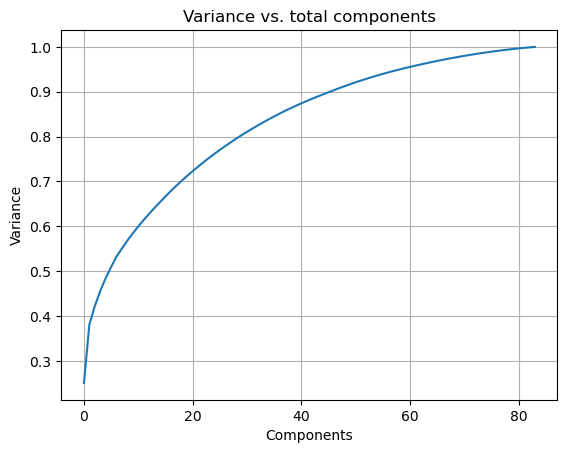

In [5]:
X = np.array(final_df['volatility'].tolist())
pca = PCA()
pca.fit(X)

# elbow method shown here
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Components')
plt.ylabel('Variance')
plt.title('Variance vs. total components')
plt.grid(True)
plt.show()

    

In the following subsection we will conduct clustering of our data, cross validation for hyper parameter tuning, analysis of different final clusters and supervised learning analysis.

### Baseline K Means and GMM Models

To compare the performance of the GMM and K-means models on our dataset, we first implemented both models using 11 clusters, corresponding to the 11 industries in the S&P 500, to explore potential industry patterns. We began by establishing a baseline, running both models on PCA-processed data without any hyperparameter tuning. To evaluate the models, we visualized the results through graphs and calculated the silhouette scores for each model. This allowed us to assess how well the models performed in clustering the data and provided insight into their overall effectiveness.

silhouette score: 0.022461650998986782


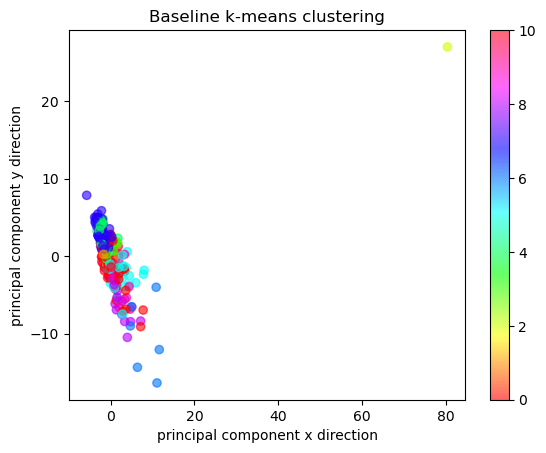

In [6]:
X = np.array(final_df['volatility'].tolist())
pca = PCA(n_components=0.95) 
X_pca = pca.fit_transform(X)

kmeans = KMeans(n_clusters=11, random_state=24) # use of 11 explained in writing above
cluster_labels = kmeans.fit_predict(X_pca)

silh_score = silhouette_score(X_pca, cluster_labels)
print('silhouette score:', silh_score)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='hsv', alpha=0.6)
plt.title('Baseline k-means clustering')
plt.xlabel('principal component x direction')
plt.ylabel('principal component y direction')
plt.colorbar()
plt.show()

silhouette score: 0.013995244903099757


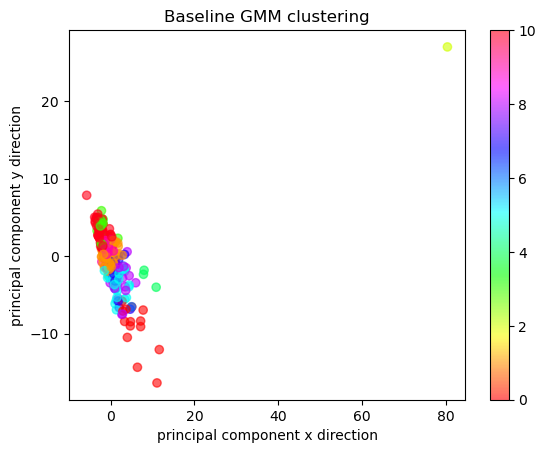

In [7]:
gmm = GaussianMixture(n_components=11)
cluster_labels = gmm.fit_predict(X_pca)

silh_score = silhouette_score(X_pca, cluster_labels)
print('silhouette score:', silh_score)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='hsv', alpha=0.6)
plt.title('Baseline GMM clustering')
plt.xlabel('principal component x direction')
plt.ylabel('principal component y direction')
plt.colorbar()
plt.show()

### Comparison of Cluster Assignment between the two techiniques 

Due to the similarity in the silhouette scores of the two techiques, we printed out the clusters which were created just to ensure the validity of our data.

In [8]:
kmeans_labels = kmeans.predict(X_pca)
gmm_labels = gmm.predict(X_pca)

# Compare the cluster assignments
print("KMeans cluster assignments:", kmeans_labels[:10])
print("GMM cluster assignments:", gmm_labels[:10])

kmeans_silhouette = silhouette_score(X_pca, kmeans_labels)
gmm_silhouette = silhouette_score(X_pca, gmm_labels)

print(f"KMeans Silhouette Score: {kmeans_silhouette}")
print(f"GMM Silhouette Score: {gmm_silhouette}")

KMeans cluster assignments: [10 10 10  9 10  7  7  8  5  7]
GMM cluster assignments: [ 1  5  1  7  1 10 10  5  8 10]
KMeans Silhouette Score: 0.022461650998986782
GMM Silhouette Score: 0.013995244903099757


### Cross validation and optimization of Baseline GMM and K Means
To optimize our GMM and K-means models for clustering stocks, we used cross-validation to determine the ideal number of clusters. This process tested the models on different data segments, providing performance scores and ensuring robustness. Cross-validation helped us identify the optimal number of clusters that maximized coherence and distinction, which we assessed using the silhouette score. 

best # of clusters: 2
Corresponding best cross validation silhouette score 0.27859681445906


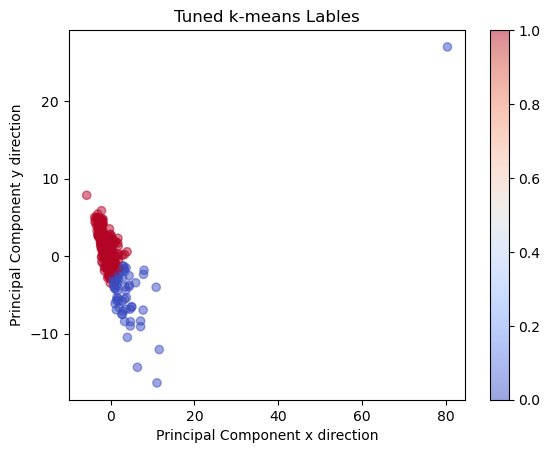

Silhouette score for graphed clustered: 0.3090119755380149


In [9]:
silhouette_scores = []

# corss validation here, note it is unseeded
for n_clusters in range(2, 19):
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(X_pca)
    silh_score = silhouette_score(X_pca, cluster_labels)
    silhouette_scores += [silh_score]

final_cluster_num = np.argmax(silhouette_scores) + 2 # add 2 because corresponding index is left shifted

print("best # of clusters:", final_cluster_num)
print("Corresponding best cross validation silhouette score", silhouette_scores[final_cluster_num - 2])

#kmeans used new found best k param
kmeans = KMeans(n_clusters=final_cluster_num, random_state=24)
cluster_labels = kmeans.fit_predict(X_pca)

#saving labl results for later analysis in finl-df
final_df['k-means label'] = cluster_labels

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='coolwarm', alpha=0.5)
plt.title('Tuned k-means Lables')
plt.xlabel('Principal Component x direction')
plt.ylabel('Principal Component y direction')
plt.colorbar()
plt.show()

# silhoutte score from graphed kmeans clustering
final_silhouette_score = silhouette_score(X_pca, cluster_labels)
print("Silhouette score for graphed clustered:", final_silhouette_score)

best # of clusters: 2
Corresponding best cross validation silhouette score 0.8631483380418771


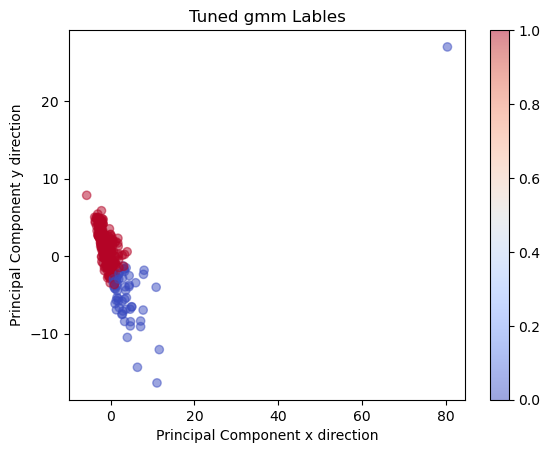

Silhouette score for graphed clustered: 0.3157494259792197


In [10]:
silhouette_scores = []

# cross validation here, note this part is unseeded
for n_components in range(2, 19):
    gmm = GaussianMixture(n_components=n_components)
    cluster_labels = gmm.fit_predict(X_pca)
    silh_score = silhouette_score(X_pca, cluster_labels)
    silhouette_scores.append(silh_score)

final_cluster_num = np.argmax(silhouette_scores) + 2

print("best # of clusters:", final_cluster_num)
print("Corresponding best cross validation silhouette score", silhouette_scores[final_cluster_num - 2])

gmm = GaussianMixture(n_components=final_cluster_num, random_state=24)
cluster_labels = gmm.fit_predict(X_pca)

# Update final_df with cluster labels
final_df['gmm labels'] = cluster_labels

# Plot the clustering labels

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='coolwarm', alpha=0.5)
plt.title('Tuned gmm Lables')
plt.xlabel('Principal Component x direction')
plt.ylabel('Principal Component y direction')
plt.colorbar()
plt.show()

final_silhouette_score = silhouette_score(X_pca, cluster_labels)
print("Silhouette score for graphed clustered:", final_silhouette_score)

### Comparing Clusters from Each Model

After improving the models, both GMM and K-means models repeeatedly selected 2 clusters in the cross validation. Since groups are now assigned to companies from the models, we will proceed with a performance analysis to learn how these clusters and models differ from each other. 

In [11]:
# peak at data frame after adding labels from our models
final_df.head(11)

,volatility,k-means label,gmm labels
Company,,,
A,"[0.4773218052326546, 1.0051671761984158, 1.827...",1,1
AAPL,"[1.702617183838854, 0.9484672021502785, 0.1951...",1,1
ABBV,"[1.011124035815082, 4.442714837058878, 0.69974...",1,1
ABEV,"[0.7025810290951009, 0.2347359508779906, 0.689...",1,1
ABT,"[1.1459365284516383, 0.1623194184859994, 0.026...",1,1
ACGL,"[0.38910046417311844, 0.5975397952022214, 1.11...",1,1
ACN,"[0.702792270799572, 1.6999443205598022, 0.5121...",1,1
ADBE,"[1.1081327004284363, 0.2637588112448539, 2.090...",0,0
ADI,"[0.5112321590414718, 2.4749178330342025, 0.182...",1,1


In [12]:
# volatility comparision of Clusters in K-means Model
final_df['avg_volatility'] = final_df['volatility'].apply(lambda x: x.mean())
final_df[['k-means label', 'avg_volatility']].groupby('k-means label').mean()

,avg_volatility
k-means label,
0,1.711945
1,0.964017


In [13]:
# volatility comparision of Clusters in GMM Model
final_df[['gmm labels', 'avg_volatility']].groupby('gmm labels').mean()

,avg_volatility
gmm labels,
0,1.727701
1,0.965927


In [14]:
kmeans_0 = final_df.index[final_df['k-means label'] == 0].values

kmeans_1 = final_df.index[final_df['k-means label'] == 1].values

gmm_0 = final_df.index[final_df['gmm labels'] == 0].values

gmm_1 = final_df.index[final_df['gmm labels'] == 1].values

#lengths of each 

print("k-means 0 length:", len(kmeans_0))
print("k-means 1 length:", len(kmeans_1), '\n')
print("gmm 0 length:", len(gmm_0))
print("gmm 1 length:", len(gmm_1), '\n')

# to visualize what these arrays look like here is a snippet of first 10 companies in the 1-label groups
print(gmm_1[0:10])
print(kmeans_1[0:10])

k-means 0 length: 63
k-means 1 length: 278 

gmm 0 length: 61
gmm 1 length: 280 

['A' 'AAPL' 'ABBV' 'ABEV' 'ABT' 'ACGL' 'ACN' 'ADI' 'ADM' 'ADP']
['A' 'AAPL' 'ABBV' 'ABEV' 'ABT' 'ACGL' 'ACN' 'ADI' 'ADM' 'ADP']


In [16]:
# Finding Average Cost Price for each company over last 3 month period in dataset
last_quart_cutoff = df1_initial['Date'].max() - timedelta(days=90)  #90 for 3 months (1 financial quarter)

final_quarter_only = df1_initial[df1_initial['Date'] >= last_quart_cutoff]

final_quarter_avgs = final_quarter_only.groupby('Company').mean()

final_quarter_avgs  = final_quarter_avgs.drop(columns=['Open', 'High', 'Low', 'Volume', "Dividends", 'Stock Splits'])
final_quarter_avgs

,Date,Close
Company,,
A,2019-02-16 04:11:25.714285824,73.538630
AAPL,2019-02-16 04:11:25.714285824,40.994696
ABBV,2019-02-16 04:11:25.714285824,65.458751
ABEV,2019-02-16 04:11:25.714285824,3.954725
ABT,2019-02-16 04:11:25.714285824,68.850457
...,...,...
XYL,2019-02-15 10:50:19.354838784,68.887666
YUM,2019-02-16 04:11:25.714285824,86.936275
ZBH,2019-02-15 10:50:19.354838784,109.818417


#### Utilize Boxplots to show performance of clusters

Given the large size of each cluster resulting from using only two clusters per model, our group determined that relying on the mean as a metric would be unfair and inaccurate for comparing average closing prices and growth across clusters. To address this issue, we implemented boxplots for each cluster, allowing us to analyze the median and various quartiles for a more precise representation of cluster differences. This approach is particularly advantageous because the mean is highly sensitive to outliers, and the substantial number of points in each cluster increases the likelihood of metrics being skewed by these outliers. By focusing on the median and quartiles, which are more robust against outliers, we achieved a less biased and more reliable comparison between clusters.

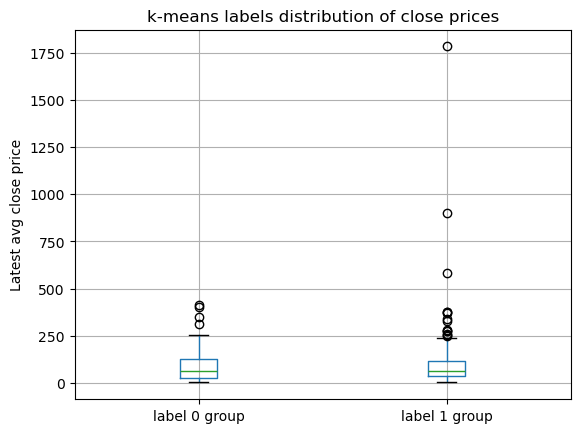

Median label 0 Median: 63.98214255438911
Lower quartile label 0: 25.675382447621182
Upper quartile label 0: 129.2516661749946 

Median for label 1 group: 63.58171402461945
Lower quartile label 1: 35.485066534980895
Upper quartile label 1: 118.07991972423734


In [17]:
# K-means section
kmean_0_avgs = final_quarter_avgs[final_quarter_avgs.index.isin(kmeans_0)]
kmean_1_avgs = final_quarter_avgs[final_quarter_avgs.index.isin(kmeans_1)]

fig, ax = plt.subplots()

box1 = kmean_0_avgs.boxplot(column='Close',  positions=[1])
box2 = kmean_1_avgs.boxplot(column='Close',  positions=[2])

ax.set_xticks([1, 2])
ax.set_xticklabels(['label 0 group', 'label 1 group'])

ax.set_ylabel('Latest avg close price')
ax.set_title('k-means labels distribution of close prices')

plt.show()

# after creating code for plot we use code below to print the actual values this is due to ranges being so different

kmeans0_median = kmean_0_avgs['Close'].median()
kmeans0_lower_q = kmean_0_avgs['Close'].quantile(0.25)
kmeans0_upper_q = kmean_0_avgs['Close'].quantile(0.75)

kmeans1_median = kmean_1_avgs['Close'].median()
kmeans1_lower_q = kmean_1_avgs['Close'].quantile(0.25)
kmeans1_upper_q = kmean_1_avgs['Close'].quantile(0.75)

print("Median label 0 Median:", kmeans0_median)
print("Lower quartile label 0:", kmeans0_lower_q)
print("Upper quartile label 0:", kmeans0_upper_q, '\n')

print("Median for label 1 group:", kmeans1_median)
print("Lower quartile label 1:", kmeans1_lower_q)
print("Upper quartile label 1:", kmeans1_upper_q)

plt.show()


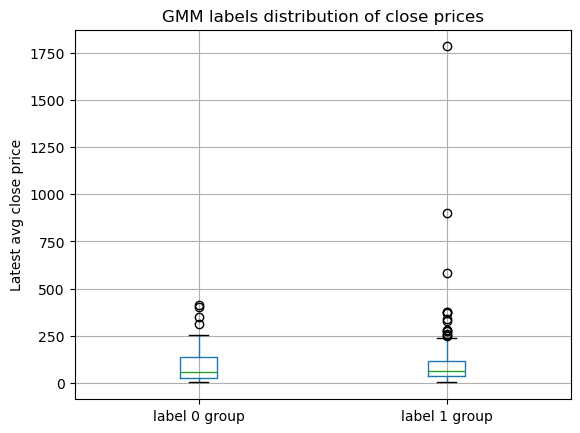

Median label 0 Median: 58.04675734989227
Lower quartile label 0: 24.5925109197223
Upper quartile label 0: 136.89571501716736 

Median for label 1 group: 64.36561993190222
Lower quartile label 1: 35.528589415171794
Upper quartile label 1: 117.66481793116009


In [18]:
# GMM section
gmm_0_avgs = final_quarter_avgs[final_quarter_avgs.index.isin(gmm_0)]
gmm_1_avgs = final_quarter_avgs[final_quarter_avgs.index.isin(gmm_1)]

fig, ax = plt.subplots()

box1 = gmm_0_avgs.boxplot(column='Close',  positions=[1])
box2 = gmm_1_avgs.boxplot(column='Close',  positions=[2])

ax.set_xticks([1, 2])
ax.set_xticklabels(['label 0 group', 'label 1 group'])

ax.set_ylabel('Latest avg close price')
ax.set_title('GMM labels distribution of close prices')

plt.show()

gmm_0_avgs = final_quarter_avgs[final_quarter_avgs.index.isin(gmm_0)]
gmm_1_avgs = final_quarter_avgs[final_quarter_avgs.index.isin(gmm_1)]

gmm0_median = gmm_0_avgs['Close'].median()
gmm0_lower_q = gmm_0_avgs['Close'].quantile(0.25)
gmm0_upper_q = gmm_0_avgs['Close'].quantile(0.75)

gmm1_median = gmm_1_avgs['Close'].median()
gmm1_lower_q = gmm_1_avgs['Close'].quantile(0.25)
gmm1_upper_q = gmm_1_avgs['Close'].quantile(0.75)

print("Median label 0 Median:", gmm0_median)
print("Lower quartile label 0:", gmm0_lower_q)
print("Upper quartile label 0:", gmm0_upper_q, '\n')

print("Median for label 1 group:", gmm1_median)
print("Lower quartile label 1:", gmm1_lower_q)
print("Upper quartile label 1:", gmm1_upper_q)


#### Analysis of Growth
In this section, we shift our focus to comparing the average growth percentages of the clusters rather than their average closing prices. Similar to the earlier approach, we rely on medians and quartiles to evaluate cluster performance. This method minimizes the influence of outliers, ensuring a more reliable and accurate comparison between clusters.

In [19]:
#calculating grow for companies
def get_last_quarter(array):
    
    return sum(array[-90:]) / 90.0

final_df['avg last 90']= final_df['volatility'].apply(get_last_quarter)

final_90_changes = final_df['avg last 90'].to_frame()
final_90_changes

kmean_0_changes = final_90_changes[final_90_changes.index.isin(kmeans_0)]
kmean_1_changes = final_90_changes[final_90_changes.index.isin(kmeans_1)]

#preview of data used:

kmean_0_changes[:5]

,avg last 90
Company,
ADBE,1.187657
ADSK,1.383876
AMAT,1.580641
AMD,2.633805
AMP,1.288907


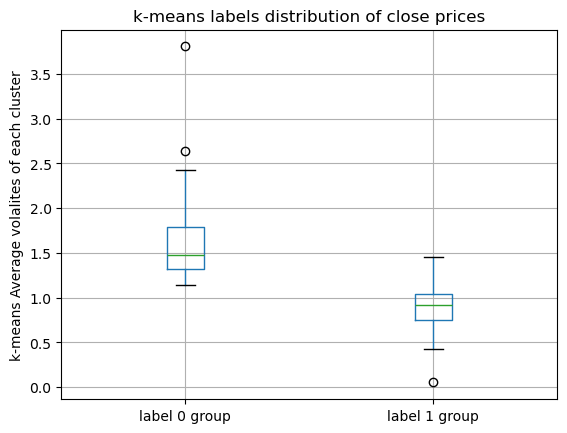

In [20]:
final_df['avg last 90']= final_df['volatility'].apply(get_last_quarter)

final_90_changes = final_df['avg last 90'].to_frame()
final_90_changes

kmean_0_changes = final_90_changes[final_90_changes.index.isin(kmeans_0)]
kmean_1_changes = final_90_changes[final_90_changes.index.isin(kmeans_1)]


fig, ax = plt.subplots()

final_box1 = kmean_0_changes.boxplot(column='avg last 90',  positions=[1])
final_box2 = kmean_1_changes.boxplot(column='avg last 90',  positions=[2])


ax.set_xticks([1, 2])
ax.set_xticklabels(['label 0 group', 'label 1 group'])

ax.set_ylabel('k-means Average volalites of each cluster')
ax.set_title('k-means labels distribution of close prices')

plt.show()

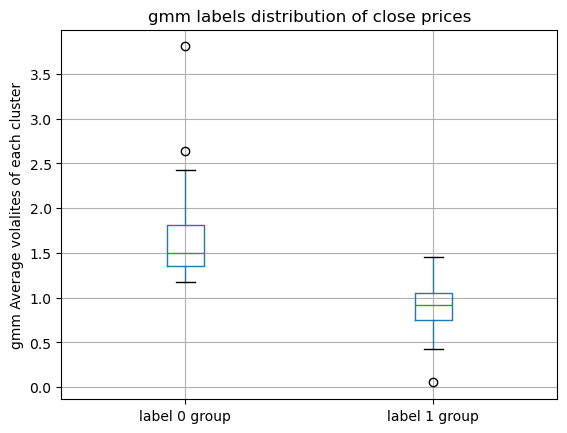

In [21]:
# GMM growth calculation
gmm_0_changes = final_90_changes[final_90_changes.index.isin(gmm_0)]
gmm_1_changes = final_90_changes[final_90_changes.index.isin(gmm_1)]


fig, ax = plt.subplots()

final_box1 = gmm_0_changes.boxplot(column='avg last 90',  positions=[1])
final_box2 = gmm_1_changes.boxplot(column='avg last 90',  positions=[2])


ax.set_xticks([1, 2])
ax.set_xticklabels(['label 0 group', 'label 1 group'])

ax.set_ylabel('gmm Average volalites of each cluster')
ax.set_title('gmm labels distribution of close prices')

plt.show()

### Recurrent Neural Network for Stock Volatility Prediction

#### Preparing Data for Neural Network (Data Wrangling)

Since we have proven that there is volatitility in our data, we will use a recurrent neural network to predict this volatility. The RNN requires a different inpur than K-Means and Gaussian Mixture Model. We loop through the percentage change list in chunks of 30 days to complete the training and split the data into train and test splits accordingly

In [22]:
data = final_df['volatility'].tolist()
sequence_length = 30

X = []
y = []

for stock_data in data:
    last_31_days = stock_data[-31:]
    if len(last_31_days) == 31:
        X.append(last_31_days[:-1])
        y.append(last_31_days[1])

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

X_train = X_train.reshape(X_train.shape[0], sequence_length, 1)
X_test = X_test.reshape(X_test.shape[0], sequence_length, 1)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

#### Initialize Model

We initialized the model's input size, hidden layer, number of recurrent layers, and output using LSTM and Linear layers, with the forward pass initializing the hidden and cell states as zero-filled tensors before progressing through the recurrent and output layers.

In [23]:
class StockRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(StockRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


#### Training


We trained the model over 10 epochs, observing decreasing training error.

In [24]:
model = StockRNN(input_size=1, hidden_size=100, num_layers=3, output_size=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor.unsqueeze(1))
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

with torch.no_grad():
    model.eval()
    y_pred = model(X_test_tensor).squeeze().numpy()
    test_loss = criterion(torch.tensor(y_pred), y_test_tensor.unsqueeze(1)).item()
    print(f'Test Loss: {test_loss:.4f}')

Epoch [1/10], Loss: 1.1866
Epoch [2/10], Loss: 1.1262
Epoch [3/10], Loss: 1.0668
Epoch [4/10], Loss: 1.0052
Epoch [5/10], Loss: 0.9387
Epoch [6/10], Loss: 0.8645
Epoch [7/10], Loss: 0.7807
Epoch [8/10], Loss: 0.6875
Epoch [9/10], Loss: 0.5941
Epoch [10/10], Loss: 0.5405
Test Loss: 0.4530


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([69, 1])) that is different to the input size (torch.Size([69])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


#### Testing
We used the trained RNN to make predictions on the volatility of each company in the dataset. We compared these predictions to the actual values using mae.After noticing a difference in the predicted and actual values, we attemped identifying if the difference is constant by scaling the predicted values with a calculated scale factor.

In [25]:
actual_values = []
predicted_values = []

for i, stock_data in enumerate(data):
    actual_value = stock_data[-1]
    actual_values.append(actual_value)

    X_tensor = torch.tensor(stock_data[-31:], dtype=torch.float32).unsqueeze(0).unsqueeze(2)

    model = StockRNN(input_size=1, hidden_size=50, num_layers=2, output_size=1)
    with torch.no_grad():
        model.eval()
        prediction = model(X_tensor).item()
    predicted_values.append(prediction)


actual_values = np.array(actual_values)
predicted_values = np.array(predicted_values)

scaling_factor = np.std(actual_values) / np.std(predicted_values)
print("Scaling Factor:", scaling_factor)

scaled_predictions = predicted_values * scaling_factor

mae_scaled = mean_absolute_error(actual_values, scaled_predictions)
mse_scaled = mean_squared_error(actual_values, scaled_predictions)

print("Original MAE:", mean_absolute_error(actual_values, predicted_values))
print("Original MSE:", mean_squared_error(actual_values, predicted_values))
print("Scaled MAE:", mae_scaled)
print("Scaled MSE:", mse_scaled)

Scaling Factor: 6.343805533771363
Original MAE: 0.657118742998448
Original MSE: 0.7859285291451267
Scaled MAE: 0.8779622514897356
Scaled MSE: 1.2425444489033504


#### Comparison to Ground Truth

In [26]:
Compare = pd.DataFrame({'Pred': predicted_values, 'Actual': actual_values})
Compare['Scaled_Pred'] = scaled_predictions
Compare

,Pred,Actual,Scaled_Pred
0,-0.080899,0.697589,-0.513210
1,0.013847,1.533313,0.087842
2,-0.135583,2.695018,-0.860113
3,-0.098689,0.911161,-0.626066
4,0.126695,0.263058,0.803727
...,...,...,...
336,-0.007424,0.838789,-0.047096
337,0.176766,0.358546,1.121371
338,-0.041907,0.452603,-0.265853
339,0.111847,0.516382,0.709533


#### Graphing Performance
When graphing the RNN's predictions (in blue) against the actual values (in orange), it is evident that the model tends to make relatively conservative predictions. The blue line remains close to zero, while the orange line exhibits higher amplitude fluctuations in both directions.


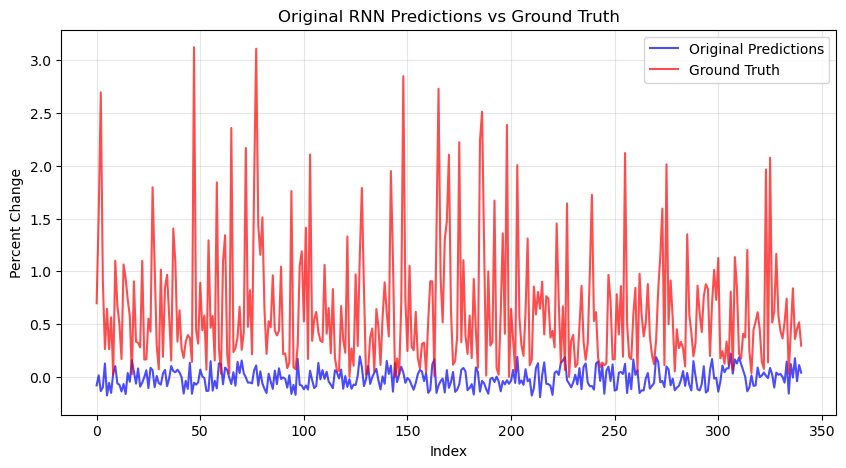

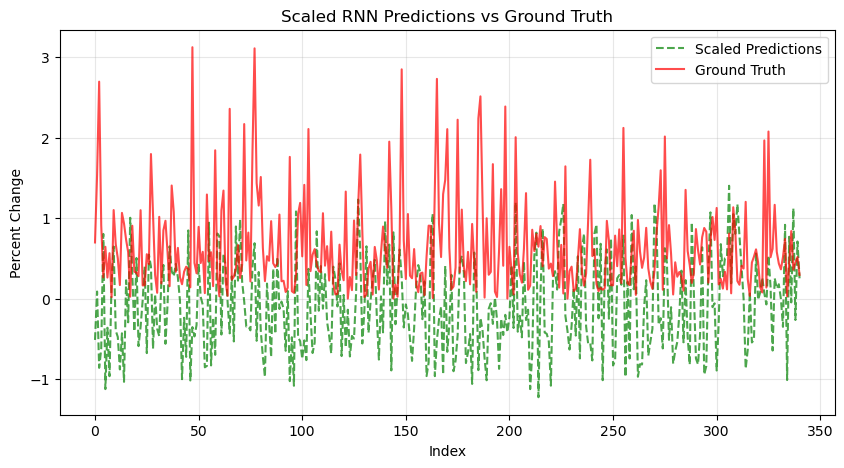

In [27]:
# First plot: Original Predictions vs Ground Truth
plt.figure(figsize=(10, 5))
plt.plot(Compare['Pred'], label='Original Predictions', color='blue', alpha=0.7)
plt.plot(Compare['Actual'], label='Ground Truth', color='red', alpha=0.7)
plt.title('Original RNN Predictions vs Ground Truth')
plt.xlabel('Index')
plt.ylabel('Percent Change')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Second plot: Scaled Predictions vs Ground Truth
plt.figure(figsize=(10, 5))
plt.plot(Compare['Scaled_Pred'], label='Scaled Predictions', color='green', linestyle='--', alpha=0.7)
plt.plot(Compare['Actual'], label='Ground Truth', color='red', alpha=0.7)
plt.title('Scaled RNN Predictions vs Ground Truth')
plt.xlabel('Index')
plt.ylabel('Percent Change')
plt.legend()
plt.grid(alpha=0.3)
plt.show()